<a href="https://colab.research.google.com/github/akbism/COVID-QA/blob/main/EDA/3_Detailed_Exploratory_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This script is for detailed exploratory data analysis of all datasets.

In [ ]:
!pip install lexical-diversity
!pip install textstat

     |████████████████████████████████| 117 kB 5.2 MB/s 
     |████████████████████████████████| 101 kB 3.4 MB/s 
     |████████████████████████████████| 2.0 MB 9.1 MB/s 


In [ ]:
# import textstat
# print(textstat.__version__)

#Setting up the google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My\ Drive/Colab\ Notebooks/LJMU/covidqa/biobert-pytorch
!pip install transformers==3.0.0


In [ ]:
import nltk
nltk.download('punkt')

# coding=utf-8
""" Finetuning the library models for question-answering on SQuAD (DistilBERT, Bert, XLM, XLNet)."""
import argparse
import glob
import logging
import os
import random
import timeit
import json
from pprint import pprint
import numpy as np
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import TensorDataset
from tqdm import tqdm, trange
from transformers import BertForSequenceClassification
from transformers import BertTokenizer
import pandas as pd
import seaborn as sns
import numpy as np
from itertools import compress

from transformers import (
    MODEL_FOR_QUESTION_ANSWERING_MAPPING,
    WEIGHTS_NAME,
    AdamW,
    AutoConfig,
    AutoModelForQuestionAnswering,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
    squad_convert_examples_to_features,
)
from transformers.data.metrics.squad_metrics import (
    compute_predictions_log_probs,
    compute_predictions_logits,
    squad_evaluate,
)
from transformers.data.processors.squad import SquadResult, SquadV1Processor, SquadV2Processor


try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

logger = logging.getLogger(__name__)

MODEL_CONFIG_CLASSES = list(MODEL_FOR_QUESTION_ANSWERING_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/LJMU/covidqa/biobert-pytorch
     |████████████████████████████████| 754 kB 5.0 MB/s 
     |████████████████████████████████| 1.2 MB 39.9 MB/s 
     |████████████████████████████████| 3.0 MB 42.8 MB/s 
     |████████████████████████████████| 895 kB 73.4 MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#Setting the parameters of the EDA

In [ ]:
class Args:
    model_type = 'bert'
    model_name_or_path = 'bert-base-cased' #'dmis-lab/biobert-base-cased-v1.1-squad'
    output_dir = './scripts/output'
    golden_file = None
    official_eval_dir = './scripts/squad_eval'
    data_dir = '/content/gdrive/MyDrive/Colab Notebooks/LJMU/covidqa/biobert-pytorch/datasets/QA/SQuAD'
    train_file = 'train-v2.0.json'
    predict_file ='dev-v2.0.json'
    
    data_dir1 = '/content/gdrive/MyDrive/Colab Notebooks/LJMU/covidqa/biobert-pytorch/datasets/QA/BioASQ/BioASQ-678b'
    train_file1 = 'BioASQ-train-factoid-6_8b-full-annotated.json'
    predict_file1 ='BioASQ-train-factoid-7b-full-annotated.json'
    
    data_dir2 = '/content/gdrive/MyDrive/Colab Notebooks/LJMU/covidqa/biobert-pytorch/datasets/QA'
    predict_file2 ='COVID-QA-Modified.json'
args=Args()

# Defining data extraction function

In [ ]:
import json
from pathlib import Path
import os
def read_squad(path, is_training=True):
    path = Path(path)
    with open(path, 'rb') as f:
        squad_dict = json.load(f)

    contexts = []
    questions = []
    answers = []
    answer_starts = []
    is_impossible_ind = []
    start_location_fractions = []
    end_location_fractions = []
  
    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']

                is_impossible = qa.get("is_impossible", False)
                if not is_impossible:
                    if is_training:
                        answer = qa["answers"][0]
                        answer_text = answer["text"]
                        start_position_character = answer["answer_start"]
                    else:
                        answers = qa["answers"][0]
                        answer_text = answer["text"]
                        start_position_character = answer["answer_start"]
                end_loc= (start_position_character+len(answer_text))/len(context)
                end_loc = end_loc if end_loc <= 1 else 0
                start_loc= start_position_character/len(context)
                start_loc = start_loc if (start_loc <= 1) or (end_loc!=0) else 0                
                # for answer in qa['answers']:
                contexts.append(context)
                questions.append(question)
                answers.append(answer_text)
                answer_starts.append(start_position_character)
                is_impossible_ind.append(is_impossible)
                start_location_fractions.append(start_loc)
                end_location_fractions.append(end_loc)
                
    return contexts, questions, answers, answer_starts, is_impossible_ind, start_location_fractions, end_location_fractions

In [ ]:
path= os.path. join(args.data_dir, args.train_file)
train_contexts, train_questions, train_answers, train_answer_starts, train_is_impossible_ind, train_start_location_fractions, train_end_location_fractions = read_squad(path)
print(len(train_contexts))
print(len(train_questions))
print(len(train_answers))
print(len(train_is_impossible_ind ))
print(len(train_start_location_fractions ))
print(len(train_end_location_fractions ))

130319
130319
130319
130319
130319
130319


In [ ]:
import textstat  # https://pypi.org/project/textstat/

# Define plotting functons

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
_, axarr = plt.subplots(1,3, figsize=(12, 4))
def hist_plot(sentence_list , words_or_sentences ='words', x_lab="Sentence count", y_lab='Frequency', stat="probability", ax=axarr[0], x_start=None, x_end=None):
  from nltk import tokenize
  data=[len(tokenize.word_tokenize(x) if words_or_sentences== 'words' else tokenize.sent_tokenize(x)) for x in sentence_list]
  x_lab=x_lab+" - no of "+ words_or_sentences
  ax1 = sns.histplot(data, stat=stat, ax=ax)
  ax1.set(xlabel=x_lab, ylabel=y_lab)
  # import pdb
  # pdb.set_trace()
  if (x_start is not None and x_end is not None):
    ax1.set(xlim=(x_start , x_end))
    ax1.set_xticks(range(1,32))

  # plt.subplots_adjust(left=None, bottom=0.5, right=None, top=None, wspace=None, hspace=None)
  # try:
  #   x_lab
  #   y_lab
  #   ax1.set(xlabel=x_lab, ylabel=y_lab)
  # except:
  #   try:
  #     x_lab
  #     ax1.set(xlabel=x_lab)
  #   except:
  #     try:
  #       y_lab
  #       ax1.set(ylabel=y_lab)
  #     except:
  #       print("No label")
  return ax1

def start_end_index_plot(train_start_location_fractions, train_end_location_fractions, data_name="SQuAD 2.0"):
  fig, axarr = plt.subplots(1,2, figsize=(8, 4))
  sns.histplot(train_start_location_fractions, ax=axarr[0],stat="probability")
  sns.histplot(train_end_location_fractions, ax=axarr[1],stat="probability")
  axarr[0].set(xlabel = 'Start location / context length (%)', ylabel='Probability', title= "Start")
  axarr[1].set(xlabel = 'End location / context length (%)', ylabel=None, title= "End")
  fig.suptitle(data_name + ": Distribution of Start/End as a % of context length", y=1.05)

from lexical_diversity import lex_div as ld
def hist_readability_score(text_list, title="Title"):
  flesch_kincaid=[textstat.flesch_reading_ease(x) for x in text_list]
  coleman_liau=[textstat.coleman_liau_index(x) for x in text_list]
  gunning_fog=[textstat.gunning_fog(x) for x in text_list]
  automated_readability_index=[textstat.automated_readability_index(x) for x in text_list]
  # lexicon_count=[textstat.lexicon_count(x) for x in text_list]       
  lexical_diversity = [ld.ttr(ld.flemmatize(x)) for x in text_list]

  fig, axarr = plt.subplots(1,5, figsize=(20,4))
  sns.histplot(flesch_kincaid, ax=axarr[0],stat="probability")
  sns.histplot(coleman_liau, ax=axarr[1],stat="probability")
  sns.histplot(gunning_fog, ax=axarr[2],stat="probability")
  sns.histplot(automated_readability_index, ax=axarr[3],stat="probability")
  sns.histplot(lexical_diversity, ax=axarr[4],stat="probability")  

  axarr[0].set(xlabel = 'Score', ylabel='Probability', title= "flesch_reading_ease")
  axarr[1].set(xlabel = 'Score', ylabel=None, title= "coleman_liau_index")
  axarr[2].set(xlabel = 'Score', ylabel=None, title= "gunning_fog")
  axarr[3].set(xlabel = 'Score', ylabel=None, title= "automated_readability_index")
  axarr[4].set(xlabel = 'Score', ylabel=None, title= "lexical_diversity(TTR)")
  fig.suptitle( ": Complexity and Readability scores: "+title, y=1.05)

# Final SQuAD Distribution Analysis

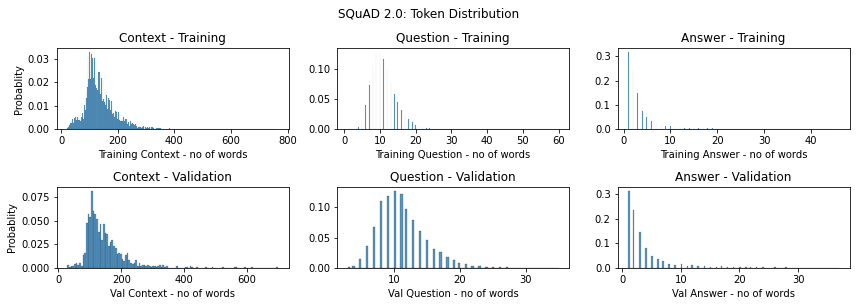

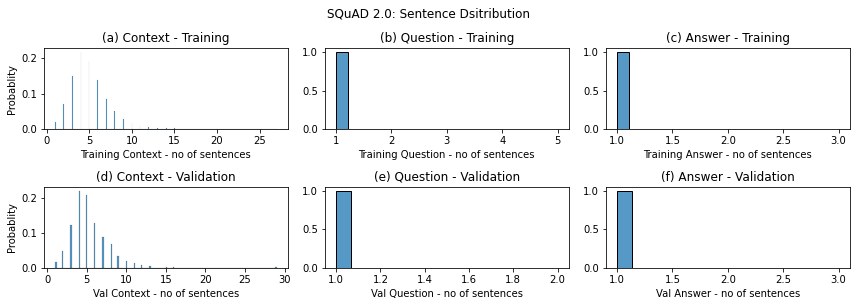

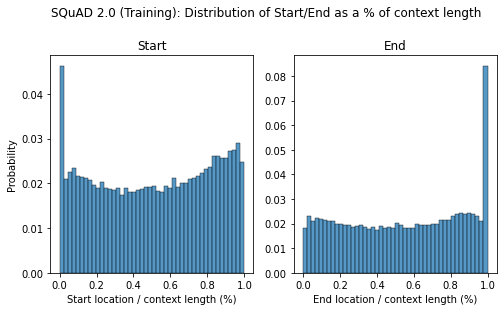

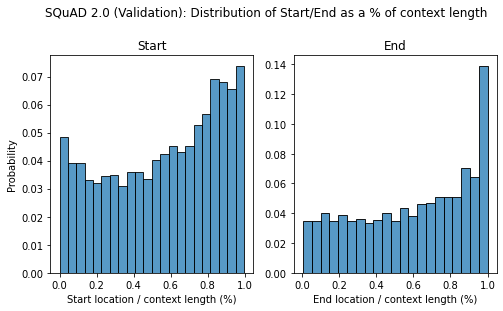

In [ ]:
path= os.path. join(args.data_dir, args.train_file)
train_contexts, train_questions, train_answers, train_answer_starts, train_is_impossible_ind, train_start_location_fractions, train_end_location_fractions= read_squad(path)
path= os.path. join(args.data_dir, args.predict_file)
val_contexts, val_questions, val_answers, val_answer_starts, val_is_impossible_ind , val_start_location_fractions, val_end_location_fractions= read_squad(path)

fig, axarr = plt.subplots(2,3, figsize=(12, 4))
axarr[0, 0].set_title("Context - Training")
axarr[0, 1].set_title("Question - Training")
axarr[0, 2].set_title("Answer - Training")
axarr[1, 0].set_title("Context - Validation")
axarr[1, 1].set_title("Question - Validation")
axarr[1, 2].set_title("Answer - Validation")
hist_plot(train_contexts, words_or_sentences ='words', x_lab="Training Context", y_lab='Probablity', stat="probability",ax=axarr[0][0]  )
hist_plot(train_questions, words_or_sentences ='words',x_lab="Training Question", y_lab=None, stat="probability",ax=axarr[0][1]  )
hist_plot(train_answers, words_or_sentences ='words',x_lab="Training Answer", y_lab=None, stat="probability",ax=axarr[0][2] )
hist_plot(val_contexts, words_or_sentences ='words', x_lab="Val Context", y_lab='Probablity', stat="probability",ax=axarr[1][0]  )
hist_plot(val_questions, words_or_sentences ='words',x_lab="Val Question", y_lab=None, stat="probability",ax=axarr[1][1]   )
hist_plot(val_answers, words_or_sentences ='words',x_lab="Val Answer", y_lab=None, stat="probability",ax=axarr[1][2] )
fig.suptitle('SQuAD 2.0: Token Distribution', y=1.05)
plt.tight_layout()
plt.show()

fig, axarr = plt.subplots(2,3, figsize=(12, 4))
axarr[0, 0].set_title("(a) Context - Training")
axarr[0, 1].set_title("(b) Question - Training")
axarr[0, 2].set_title("(c) Answer - Training")
axarr[1, 0].set_title("(d) Context - Validation")
axarr[1, 1].set_title("(e) Question - Validation")
axarr[1, 2].set_title("(f) Answer - Validation")
hist_plot(train_contexts, words_or_sentences ='sentences', x_lab="Training Context", y_lab='Probablity', stat="probability",ax=axarr[0][0]  )
hist_plot(train_questions, words_or_sentences ='sentences',x_lab="Training Question", y_lab=None, stat="probability",ax=axarr[0][1]  )
hist_plot(train_answers, words_or_sentences ='sentences',x_lab="Training Answer", y_lab=None, stat="probability",ax=axarr[0][2] )
hist_plot(val_contexts, words_or_sentences ='sentences', x_lab="Val Context", y_lab='Probablity', stat="probability",ax=axarr[1][0]  )
hist_plot(val_questions, words_or_sentences ='sentences',x_lab="Val Question", y_lab=None, stat="probability",ax=axarr[1][1]   )
hist_plot(val_answers, words_or_sentences ='sentences',x_lab="Val Answer", y_lab=None, stat="probability",ax=axarr[1][2] )
fig.suptitle('SQuAD 2.0: Sentence Dsitribution', y=1.05)
plt.tight_layout()

start_end_index_plot(train_start_location_fractions, train_end_location_fractions, data_name="SQuAD 2.0 (Training)")
start_end_index_plot(val_start_location_fractions, val_end_location_fractions, data_name="SQuAD 2.0 (Validation)")

In [ ]:
import pickle
# Read the data from the file
with open('SQuAD_Q_Types_train.pkl', 'rb') as fid:
     train_qtype = pickle.load(fid)

In [ ]:
train_qtype[91000:91010]

array(['ENTY', 'ENTY', 'LOC', 'ENTY', 'ENTY', 'ENTY', 'ENTY', 'LOC',
       'HUM', 'ENTY'], dtype='<U4')

In [ ]:
train_questions[91000:91010]

['Insects have what kind of protein content?',
 'What is the term for eating insects?',
 'Where is eating insects considered taboo?',
 'What ancient world insect is considered symbolic?',
 'Cicadas symbolize immortality in what culture?',
 'What kind of ants are symbolic among the Australian Aborigines?',
 'The praying mantis symbolizes patience and what else?',
 'Witchety grubs serve as personal clan totems in what country?',
 'What do all living humans belong to?',
 'What species are all humans?']

In [ ]:
import pandas as pd
temp=pd.crosstab(pd.Series(train_is_impossible_ind), pd.Series(train_qtype)).apply(lambda r: r/r.sum(), axis=0).T

Text(0, 0.5, 'Fraction')

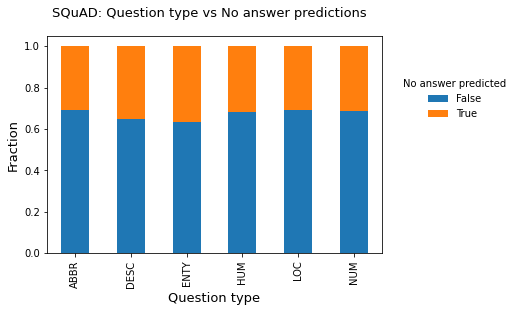

In [ ]:
temp.plot.bar(stacked=True)
# plt.legend(title='SQuAD Question Type vs No answer')
plt.suptitle('SQuAD: Question type vs No answer predictions', fontsize=13)
# plt.subplots_adjust(left=0.1, bottom=0.1, right=0.75)
plt.legend(loc='lower left', bbox_to_anchor= (1.05, 0.6),borderaxespad=0, frameon=False , title="No answer predicted")
plt.xlabel('Question type', size=13)
plt.ylabel('Fraction', size=13)


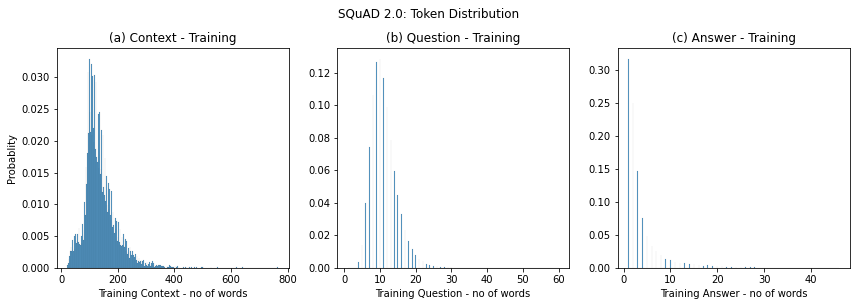

In [ ]:
path= os.path. join(args.data_dir, args.train_file)
train_contexts, train_questions, train_answers, train_answer_starts, train_is_impossible_ind, train_start_location_fractions, train_end_location_fractions= read_squad(path)
path= os.path. join(args.data_dir, args.predict_file)
val_contexts, val_questions, val_answers, val_answer_starts, val_is_impossible_ind , val_start_location_fractions, val_end_location_fractions= read_squad(path)

fig, axarr = plt.subplots(1,3, figsize=(12, 4))
axarr[0].set_title("(a) Context - Training")
axarr[1].set_title("(b) Question - Training")
axarr[2].set_title("(c) Answer - Training")
# axarr[1, 0].set_title("Context - Validation")
# axarr[1, 1].set_title("Question - Validation")
# axarr[1, 2].set_title("Answer - Validation")
hist_plot(train_contexts, words_or_sentences ='words', x_lab="Training Context", y_lab='Probablity', stat="probability",ax=axarr[0])#  , x_start=0, x_end=10000)
hist_plot(train_questions, words_or_sentences ='words',x_lab="Training Question", y_lab=None, stat="probability",ax=axarr[1])#, x_start=0, x_end=40  )
hist_plot(train_answers, words_or_sentences ='words',x_lab="Training Answer", y_lab=None, stat="probability",ax=axarr[2])# , x_start=0, x_end=150)
# hist_plot(val_contexts, words_or_sentences ='words', x_lab="Val Context", y_lab='Probablity', stat="probability",ax=axarr[1][0]  )
# hist_plot(val_questions, words_or_sentences ='words',x_lab="Val Question", y_lab=None, stat="probability",ax=axarr[1][1]   )
# hist_plot(val_answers, words_or_sentences ='words',x_lab="Val Answer", y_lab=None, stat="probability",ax=axarr[1][2] )
fig.suptitle('SQuAD 2.0: Token Distribution', y=1.05)
plt.tight_layout()
plt.show()

# fig, axarr = plt.subplots(1,3, figsize=(12, 4))
# axarr[0].set_title("(d) Context - Training")
# axarr[1].set_title("(e) Question - Training")
# axarr[2].set_title("(f) Answer - Training")
# # axarr[1, 0].set_title("(d) Context - Validation")
# # axarr[1, 1].set_title("(e) Question - Validation")
# # axarr[1, 2].set_title("(f) Answer - Validation")
# hist_plot(train_contexts, words_or_sentences ='sentences', x_lab="Training Context", y_lab='Probablity', stat="probability",ax=axarr[0]  )
# hist_plot(train_questions, words_or_sentences ='sentences',x_lab="Training Question", y_lab=None, stat="probability",ax=axarr[1]  )
# hist_plot(train_answers, words_or_sentences ='sentences',x_lab="Training Answer", y_lab=None, stat="probability",ax=axarr[2] )
# # hist_plot(val_contexts, words_or_sentences ='sentences', x_lab="Val Context", y_lab='Probablity', stat="probability",ax=axarr[1][0]  )
# # hist_plot(val_questions, words_or_sentences ='sentences',x_lab="Val Question", y_lab=None, stat="probability",ax=axarr[1][1]   )
# # hist_plot(val_answers, words_or_sentences ='sentences',x_lab="Val Answer", y_lab=None, stat="probability",ax=axarr[1][2] )
# fig.suptitle('SQuAD 2.0: Sentence Dsitribution', y=1.05)
# plt.tight_layout()

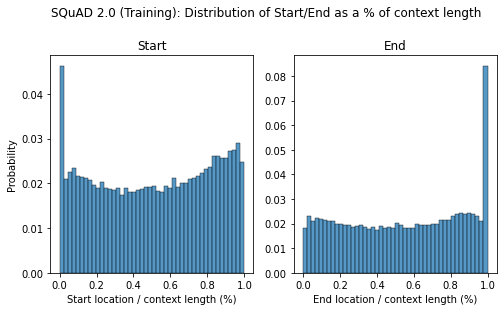

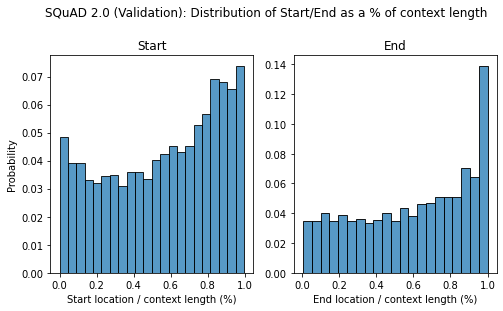

In [ ]:
path= os.path. join(args.data_dir, args.train_file)
train_contexts, train_questions, train_answers, train_answer_starts, train_is_impossible_ind, train_start_location_fractions, train_end_location_fractions= read_squad(path)
path= os.path. join(args.data_dir, args.predict_file)
val_contexts, val_questions, val_answers, val_answer_starts, val_is_impossible_ind , val_start_location_fractions, val_end_location_fractions= read_squad(path)

start_end_index_plot(train_start_location_fractions, train_end_location_fractions, data_name="(a) SQuAD 2.0 (Training)")
start_end_index_plot(val_start_location_fractions, val_end_location_fractions, data_name="(b) SQuAD 2.0 (Validation)")

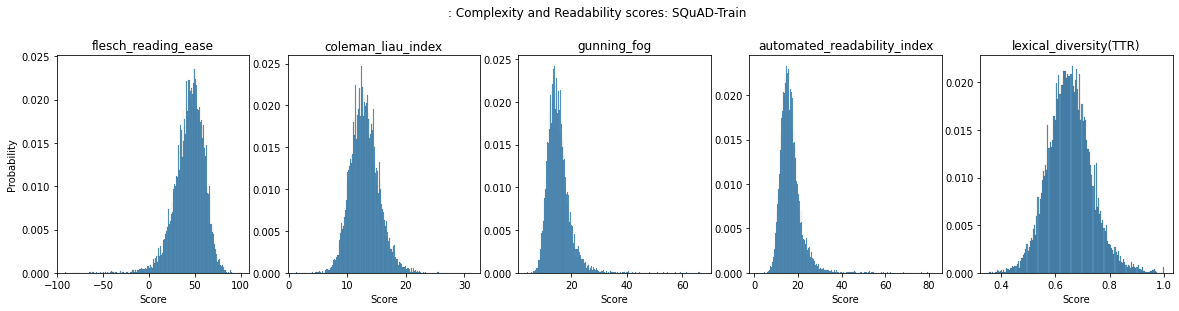

In [ ]:
path= os.path. join(args.data_dir, args.train_file)
train_contexts, train_questions, train_answers, train_answer_starts, train_is_impossible_ind, train_start_location_fractions, train_end_location_fractions= read_squad(path)
hist_readability_score(train_contexts, "SQuAD-Train")

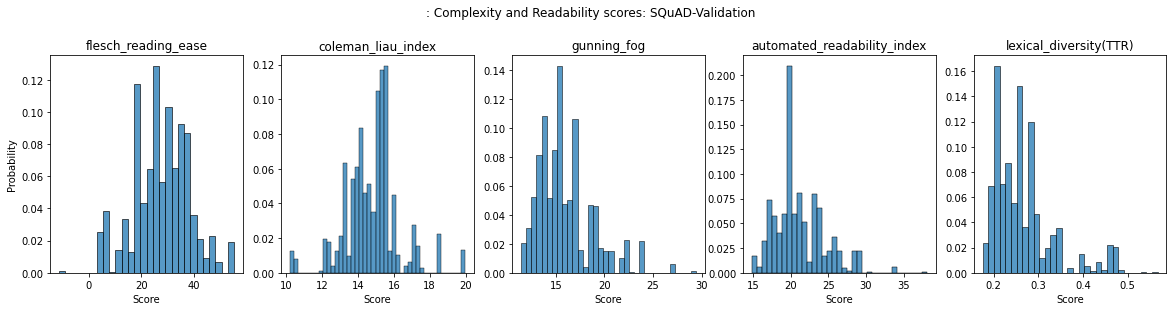

In [ ]:
hist_readability_score(val_contexts, "SQuAD-Validation")

# Final BioASQ Distribution Analysis

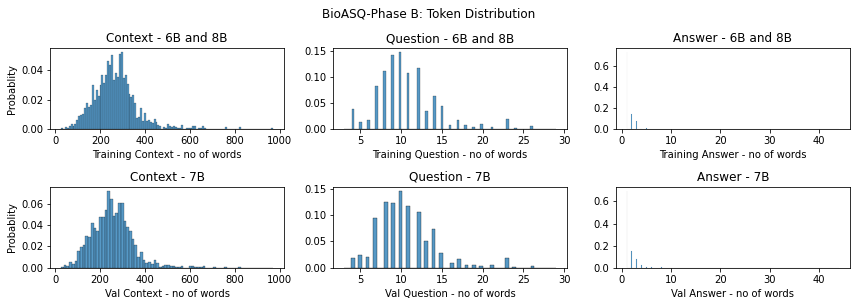

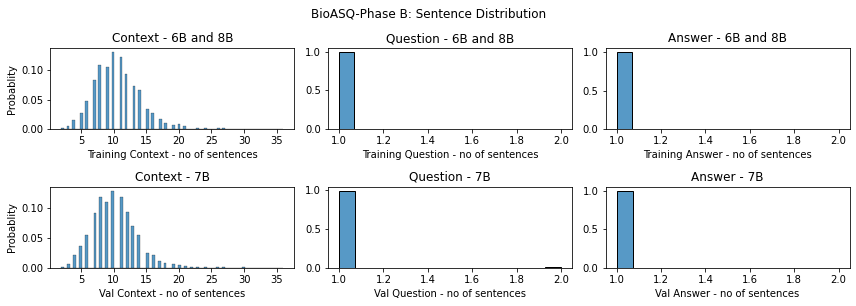

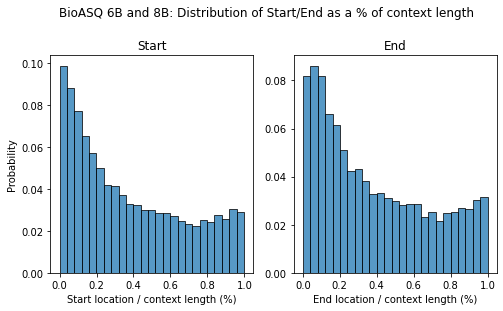

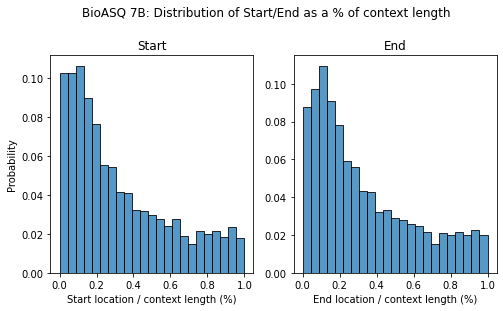

In [ ]:
path= os.path.join(args.data_dir1, args.train_file1)
train_contexts, train_questions, train_answers, train_answer_starts, train_is_impossible_ind, train_start_location_fractions, train_end_location_fractions= read_squad(path)
path= os.path. join(args.data_dir1, args.predict_file1)
val_contexts, val_questions, val_answers, val_answer_starts, val_is_impossible_ind , val_start_location_fractions, val_end_location_fractions= read_squad(path)
fig, axarr = plt.subplots(2,3, figsize=(12, 4))
axarr[0, 0].set_title("Context - 6B and 8B")
axarr[0, 1].set_title("Question - 6B and 8B")
axarr[0, 2].set_title("Answer - 6B and 8B")
axarr[1, 0].set_title("Context - 7B")
axarr[1, 1].set_title("Question - 7B")
axarr[1, 2].set_title("Answer - 7B")
hist_plot(train_contexts, words_or_sentences ='words', x_lab="Training Context", y_lab='Probablity', stat="probability",ax=axarr[0][0]  )
hist_plot(train_questions, words_or_sentences ='words',x_lab="Training Question", y_lab=None, stat="probability",ax=axarr[0][1]  )
hist_plot(train_answers, words_or_sentences ='words',x_lab="Training Answer", y_lab=None, stat="probability",ax=axarr[0][2] )
hist_plot(val_contexts, words_or_sentences ='words', x_lab="Val Context", y_lab='Probablity', stat="probability",ax=axarr[1][0]  )
hist_plot(val_questions, words_or_sentences ='words',x_lab="Val Question", y_lab=None, stat="probability",ax=axarr[1][1]   )
hist_plot(val_answers, words_or_sentences ='words',x_lab="Val Answer", y_lab=None, stat="probability",ax=axarr[1][2] )
fig.suptitle('BioASQ-Phase B: Token Distribution', y=1.05)
plt.tight_layout()
plt.show()

fig, axarr = plt.subplots(2,3, figsize=(12, 4))
axarr[0, 0].set_title("Context - 6B and 8B")
axarr[0, 1].set_title("Question - 6B and 8B")
axarr[0, 2].set_title("Answer - 6B and 8B")
axarr[1, 0].set_title("Context - 7B")
axarr[1, 1].set_title("Question - 7B")
axarr[1, 2].set_title("Answer - 7B")
hist_plot(train_contexts, words_or_sentences ='sentences', x_lab="Training Context", y_lab='Probablity', stat="probability",ax=axarr[0][0]  )
hist_plot(train_questions, words_or_sentences ='sentences',x_lab="Training Question", y_lab=None, stat="probability",ax=axarr[0][1]  )
hist_plot(train_answers, words_or_sentences ='sentences',x_lab="Training Answer", y_lab=None, stat="probability",ax=axarr[0][2] )
hist_plot(val_contexts, words_or_sentences ='sentences', x_lab="Val Context", y_lab='Probablity', stat="probability",ax=axarr[1][0]  )
hist_plot(val_questions, words_or_sentences ='sentences',x_lab="Val Question", y_lab=None, stat="probability",ax=axarr[1][1]   )
hist_plot(val_answers, words_or_sentences ='sentences',x_lab="Val Answer", y_lab=None, stat="probability",ax=axarr[1][2] )
fig.suptitle('BioASQ-Phase B: Sentence Distribution', y=1.05)
plt.tight_layout()
plt.show()

start_end_index_plot(train_start_location_fractions, train_end_location_fractions, data_name="BioASQ 6B and 8B")
start_end_index_plot(val_start_location_fractions, val_end_location_fractions, data_name="BioASQ 7B")

In [ ]:
# i= [1,2,3,4,5,6,7,8,9]
# print([print(x) for x in map(val_contexts.__getitem__, i)     ])
# print([print(x) for x in map(val_questions.__getitem__, i)     ])
# print([print(x) for x in map(val_answers.__getitem__, i)     ])

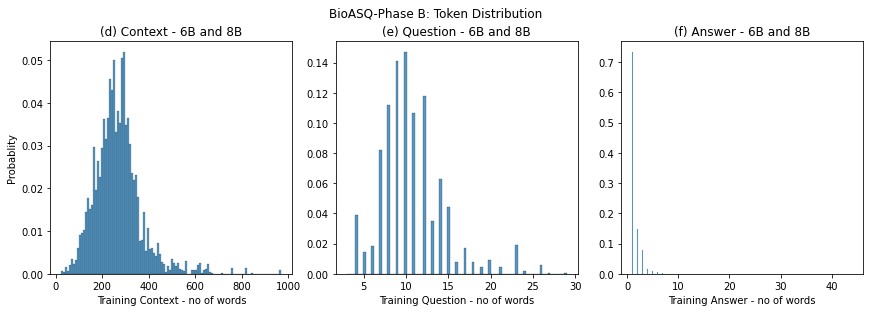

In [ ]:
path= os.path. join(args.data_dir1, args.train_file1)
train_contexts, train_questions, train_answers, train_answer_starts, train_is_impossible_ind, train_start_location_fractions, train_end_location_fractions= read_squad(path)
path= os.path. join(args.data_dir1, args.predict_file1)
val_contexts, val_questions, val_answers, val_answer_starts, val_is_impossible_ind , val_start_location_fractions, val_end_location_fractions= read_squad(path)

fig, axarr = plt.subplots(1,3, figsize=(12, 4))
axarr[0].set_title("(d) Context - 6B and 8B")
axarr[1].set_title("(e) Question - 6B and 8B")
axarr[2].set_title("(f) Answer - 6B and 8B")
hist_plot(train_contexts, words_or_sentences ='words', x_lab="Training Context", y_lab='Probablity', stat="probability",ax=axarr[0]  )
hist_plot(train_questions, words_or_sentences ='words',x_lab="Training Question", y_lab=None, stat="probability",ax=axarr[1]  )
hist_plot(train_answers, words_or_sentences ='words',x_lab="Training Answer", y_lab=None, stat="probability",ax=axarr[2])
fig.suptitle('BioASQ-Phase B: Token Distribution', y=1.05)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

# fig, axarr = plt.subplots(1,3, figsize=(12, 4))
# axarr[0].set_title("(d) Context - 6B and 8B")
# axarr[1].set_title("(e) Question - 6B and 8B")
# axarr[2].set_title("(f) Answer - 6B and 8B")

# hist_plot(train_contexts, words_or_sentences ='sentences', x_lab="Training Context", y_lab='Probablity', stat="probability",ax=axarr[0]  )
# hist_plot(train_questions, words_or_sentences ='sentences',x_lab="Training Question", y_lab=None, stat="probability",ax=axarr[1]  )
# hist_plot(train_answers, words_or_sentences ='sentences',x_lab="Training Answer", y_lab=None, stat="probability",ax=axarr[2] )
# # hist_plot(val_contexts, words_or_sentences ='sentences', x_lab="Val Context", y_lab='Probablity', stat="probability",ax=axarr[1][0]  )
# # hist_plot(val_questions, words_or_sentences ='sentences',x_lab="Val Question", y_lab=None, stat="probability",ax=axarr[1][1]   )
# # hist_plot(val_answers, words_or_sentences ='sentences',x_lab="Val Answer", y_lab=None, stat="probability",ax=axarr[1][2] )
# fig.suptitle('BioASQ-Phase B: Sentence Distribution', y=1.05)
# plt.tight_layout()

In [ ]:
hist_plot(train_answers, words_or_sentences ='words',x_lab="Training Answer", y_lab=None, stat="probability",ax=axarr[2] )
fig.suptitle('BioASQ-Phase B: Token Distribution', y=1.05)
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

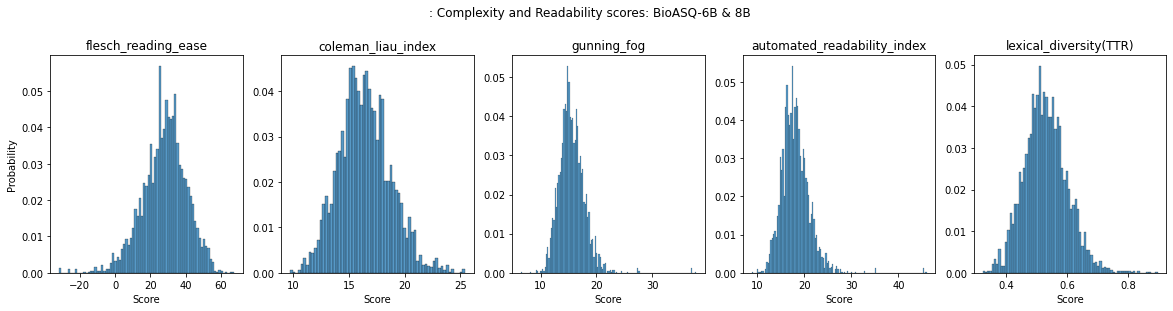

In [ ]:
path= os.path.join(args.data_dir1, args.train_file1)
train_contexts, train_questions, train_answers, train_answer_starts, train_is_impossible_ind, train_start_location_fractions, train_end_location_fractions= read_squad(path)
path= os.path. join(args.data_dir1, args.predict_file1)
val_contexts, val_questions, val_answers, val_answer_starts, val_is_impossible_ind , val_start_location_fractions, val_end_location_fractions= read_squad(path)
hist_readability_score(train_contexts, "BioASQ-6B & 8B")

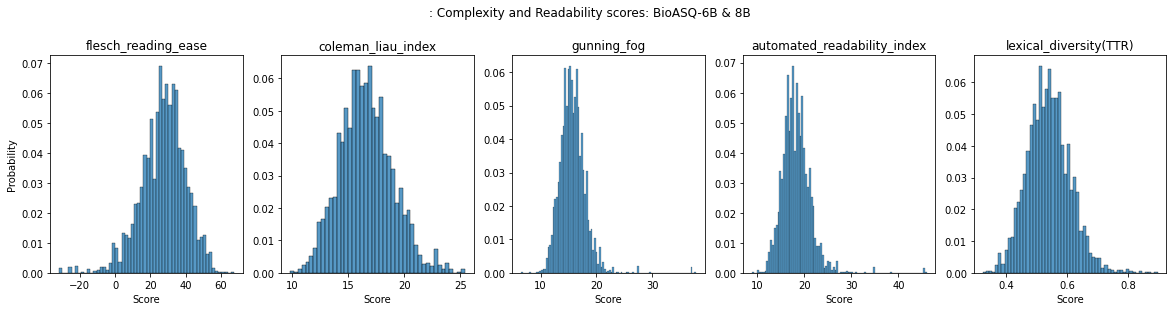

In [ ]:
hist_readability_score(val_contexts, "BioASQ-6B & 8B")

# Final COVID-QA Distribution Analysis

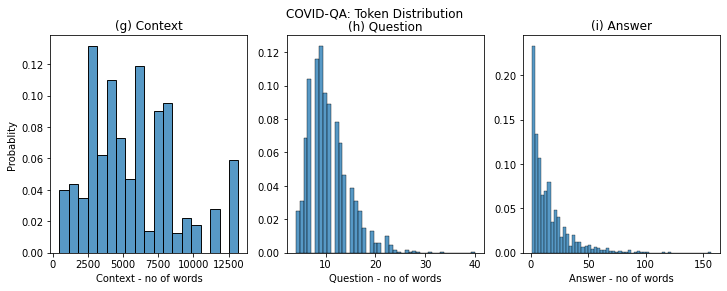

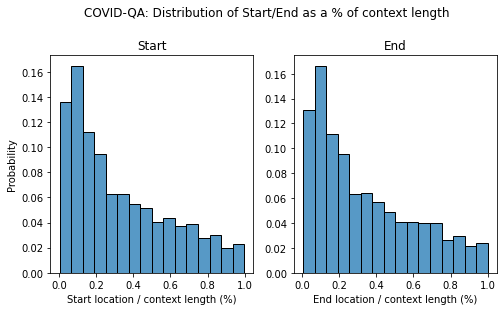

In [ ]:
path= os.path. join(args.data_dir2, args.predict_file2)
val_contexts, val_questions, val_answers, val_answer_starts, val_is_impossible_ind , val_start_location_fractions, val_end_location_fractions= read_squad(path)

fig, axarr = plt.subplots(1,3, figsize=(12, 4))
axarr[0].set_title("(g) Context")
axarr[1].set_title("(h) Question")
axarr[2].set_title("(i) Answer")
hist_plot(val_contexts, words_or_sentences ='words', x_lab="Context", y_lab='Probablity', stat="probability",ax=axarr[0]  )
hist_plot(val_questions, words_or_sentences ='words',x_lab="Question", y_lab=None, stat="probability",ax=axarr[1]  )
hist_plot(val_answers, words_or_sentences ='words',x_lab="Answer", y_lab=None, stat="probability",ax=axarr[2]  )
fig.suptitle('COVID-QA: Token Distribution')

# fig, axarr = plt.subplots(1,3, figsize=(12, 4))
# hist_plot(val_contexts, words_or_sentences ='sentences', x_lab="Context", y_lab='Probablity', stat="probability",ax=axarr[0]  )
# hist_plot(val_questions, words_or_sentences ='sentences',x_lab="Question", y_lab=None, stat="probability",ax=axarr[1]  )
# hist_plot(val_answers, words_or_sentences ='sentences',x_lab="Answer", y_lab=None, stat="probability",ax=axarr[2]  )
# fig.suptitle('COVID-QA: Sentence Distribution')

start_end_index_plot(val_start_location_fractions, val_end_location_fractions, data_name="COVID-QA")

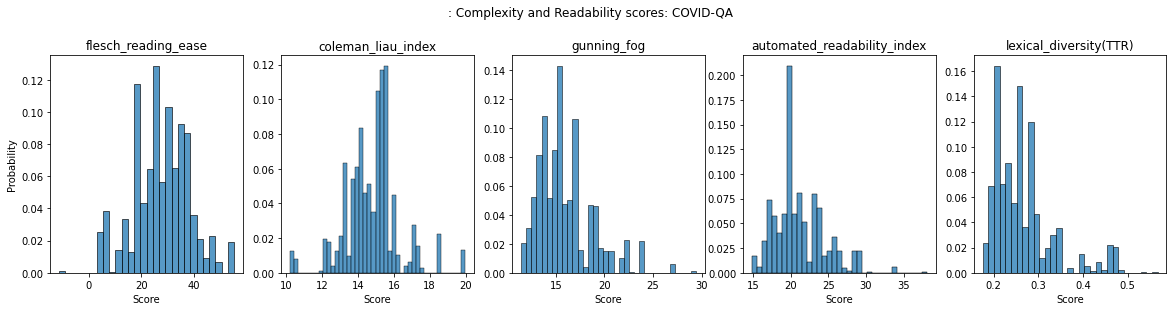

In [ ]:
path= os.path. join(args.data_dir2, args.predict_file2)
val_contexts, val_questions, val_answers, val_answer_starts, val_is_impossible_ind , val_start_location_fractions, val_end_location_fractions= read_squad(path)

hist_readability_score(val_contexts, "COVID-QA")

In [ ]:
  from nltk import tokenize

In [ ]:
from collections import Counter
Counter(data)

Counter({1: 1878, 2: 109, 3: 24, 4: 4, 5: 3, 6: 1})

In [ ]:
# from itertools import compress
# list(compress(val_answers, [x>1 for x in data]))

In [ ]:
# from itertools import compress
# list(compress(val_questions, [x>1 for x in data]))

In [ ]:
path= os.path. join(args.data_dir, args.train_file)
train_contexts0, train_questions0, train_answers0, train_answer_starts0, train_is_impossible_ind0, train_start_location_fractions0, train_end_location_fractions0= read_squad(path)

path= os.path. join(args.data_dir1, args.train_file1)
train_contexts1, train_questions1, train_answers1, train_answer_starts1, train_is_impossible_ind1, train_start_location_fractions1, train_end_location_fractions1= read_squad(path)

path= os.path. join(args.data_dir2, args.predict_file2)
train_contexts2, train_questions2, train_answers2, train_answer_starts2, train_is_impossible_ind2, train_start_location_fractions2, train_end_location_fractions2= read_squad(path)

In [ ]:
# def start_end_index_plot(train_start_location_fractions, train_end_location_fractions, data_name="SQuAD 2.0", col=0):
#   sns.histplot(train_start_location_fractions, ax=axarr[0][col],stat="probability")
#   sns.histplot(train_end_location_fractions, ax=axarr[1][col],stat="probability")
#   axarr[0][col].set(xlabel = 'Start location / context length (%)', ylabel='Probability', title= "Start")
#   axarr[1][col].set(xlabel = 'End location / context length (%)', ylabel=None, title= "End")
#   # fig.suptitle(data_name + ": Distribution of Start/End as a % of context length", y=1.05)

In [ ]:
# fig, axarr = plt.subplots(2,3, figsize=(12, 4))
# start_end_index_plot(train_start_location_fractions0, train_end_location_fractions0, data_name="SQuAD", col=0)
# start_end_index_plot(train_start_location_fractions1, train_end_location_fractions1, data_name="BioASQ 6B & 8B", col=1)
# start_end_index_plot(train_start_location_fractions2, train_end_location_fractions2, data_name="COVID-QA", col=2)

#Answer start & Answer End

In [ ]:
start_end0 = pd.DataFrame(list(zip(train_start_location_fractions0, train_end_location_fractions0, ["SQuAD (Train)" for x in train_end_location_fractions0])),columns =['Start Location', 'End Location', 'Dataset'])
start_end1= pd.DataFrame(list(zip(train_start_location_fractions1, train_end_location_fractions1, ["BioASQ (6B & 8B)" for x in train_end_location_fractions0])),columns =['Start Location', 'End Location', 'Dataset'])
start_end2 = pd.DataFrame(list(zip(train_start_location_fractions2, train_end_location_fractions2, ["COVID-QA" for x in train_end_location_fractions0])),columns =['Start Location', 'End Location', 'Dataset'])
start_end = pd.concat([start_end0, start_end1, start_end2])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

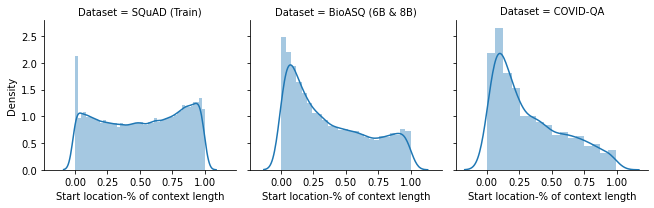

In [ ]:
# Form a facetgrid using columns with a hue 
sea = sns.FacetGrid(start_end[['Start Location',"Dataset" ]], col = "Dataset")
    
# map the above form facetgrid with some attributes   
sea.map(sns.distplot, 'Start Location',  hist_kws=dict( linewidth=1.2))
sea.set(xlabel="Start location-% of context length")
sea.set(ylabel="Density")
# adding legend
# sea.add_legend()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

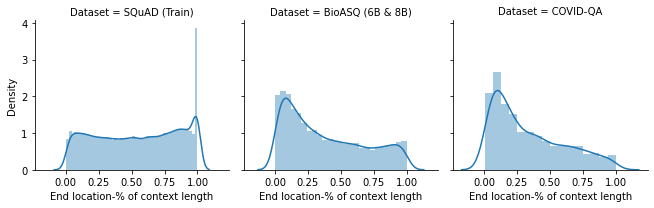

In [ ]:
# Form a facetgrid using columns with a hue 
sea = sns.FacetGrid(start_end[['End Location',"Dataset" ]], col = "Dataset")
    
# map the above form facetgrid with some attributes   
sea.map(sns.distplot, 'End Location',  hist_kws=dict( linewidth=1.2))
sea.set(xlabel="End location-% of context length")
sea.set(ylabel="Density")
# adding legend
# sea.add_legend()

#Context

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

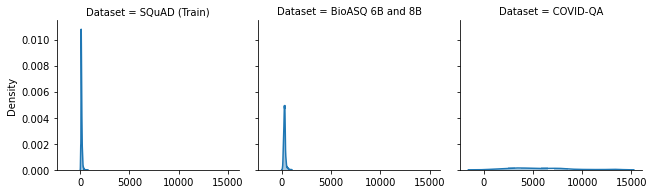

In [ ]:
train_contexts0 =[ (len(tokenize.word_tokenize(x)), "SQuAD (Train)") for x in train_contexts0]
train_contexts1 =[ (len(tokenize.word_tokenize(x)), "BioASQ 6B and 8B") for x in train_contexts1]
train_contexts2 =[ (len(tokenize.word_tokenize(x)), "COVID-QA") for x in train_contexts2]

# train_questions =[ (len(tokenize.word_tokenize(x)), "Questions - 6B and 8B") for x in train_questions]
# train_answers =[ (len(tokenize.word_tokenize(x)), "Answers - 6B and 8B") for x in train_answers]

contexts = pd.DataFrame(train_contexts0 + train_contexts1 +train_contexts2, columns=['Context Token Count', 'Dataset'])

# Form a facetgrid using columns with a hue 
sea = sns.FacetGrid(contexts, col = "Dataset")
    
# map the above form facetgrid with some attributes   
sea.map(sns.distplot, 'Context Token Count',  hist_kws=dict( linewidth=1.2))
sea.set(xlabel=None)
sea.set(ylabel="Density")
# adding legend
# sea.add_legend()

In [ ]:
contexts.groupby('Dataset').describe().T

Dataset            Contexts - BioASQ 6B and 8B  ...  Contexts - SQuAD
Token_count count                 14919.000000  ...     130319.000000
            mean                    269.385348  ...        137.684881
            std                     100.676869  ...         56.954020
            min                      25.000000  ...         22.000000
            25%                     208.000000  ...        102.000000
            50%                     261.000000  ...        126.000000
            75%                     314.000000  ...        163.000000
            max                     971.000000  ...        766.000000

[8 rows x 3 columns]

In [ ]:
contexts.shape

(147257, 2)

#Question

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

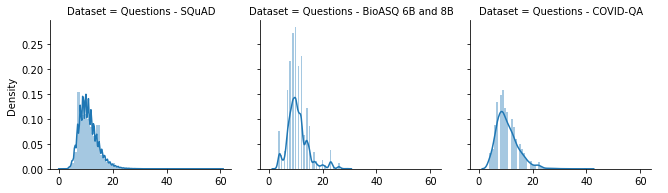

In [ ]:
train_questions0 =[ (len(tokenize.word_tokenize(x)), "Questions - SQuAD") for x in train_questions0]
train_questions1 =[ (len(tokenize.word_tokenize(x)), "Questions - BioASQ 6B and 8B") for x in train_questions1]
train_questions2 =[ (len(tokenize.word_tokenize(x)), "Questions - COVID-QA") for x in train_questions2]

questions = pd.DataFrame(train_questions0 + train_questions1 +train_questions2, columns=['Token_count', 'Dataset'])

# Form a facetgrid using columns with a hue 
sea = sns.FacetGrid(questions, col = "Dataset")
    
# map the above form facetgrid with some attributes   
sea.map(sns.distplot, "Token_count",  hist_kws=dict( linewidth=1.2))
sea.set(xlabel=None)
sea.set(ylabel="Density")
# adding legend
sea.add_legend()

In [ ]:
questions.groupby('Dataset').describe().T

Dataset            Questions - BioASQ 6B and 8B  ...  Questions - SQuAD
Token_count count                  14919.000000  ...      130319.000000
            mean                      10.723306  ...          11.106707
            std                        3.836550  ...           3.567908
            min                        3.000000  ...           1.000000
            25%                        8.000000  ...           9.000000
            50%                       10.000000  ...          11.000000
            75%                       12.000000  ...          13.000000
            max                       29.000000  ...          60.000000

[8 rows x 3 columns]

#Answer

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

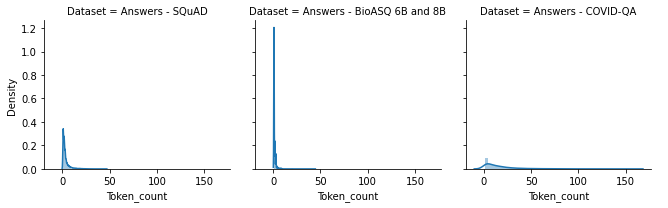

In [ ]:
train_answers0 =[ (len(tokenize.word_tokenize(x)), "Answers - SQuAD") for x in train_answers0]
train_answers1 =[ (len(tokenize.word_tokenize(x)), "Answers - BioASQ 6B and 8B") for x in train_answers1]
train_answers2 =[ (len(tokenize.word_tokenize(x)), "Answers - COVID-QA") for x in train_answers2]

answers = pd.DataFrame(train_answers0 + train_answers1 +train_answers2, columns=['Token_count', 'Dataset'])

# Form a facetgrid using columns with a hue 
sea = sns.FacetGrid(answers, col = "Dataset")
# map the above form facetgrid with some attributes   
sea.map(sns.distplot, "Token_count",  hist_kws=dict( linewidth=1.2))
sea.set(ylabel="Density")
# adding legend
sea.add_legend()
# plt.subplots_adjust(hspace=0.4, wspace=0.4)

In [ ]:
answers.groupby('Dataset').describe().T

Dataset            Answers - BioASQ 6B and 8B  ...  Answers - SQuAD
Token_count count                14919.000000  ...    130319.000000
            mean                     1.538173  ...         3.557954
            std                      1.630131  ...         3.988944
            min                      1.000000  ...         1.000000
            25%                      1.000000  ...         1.000000
            50%                      1.000000  ...         2.000000
            75%                      2.000000  ...         4.000000
            max                     44.000000  ...        46.000000

[8 rows x 3 columns]

#flesch_kincaid

In [ ]:
path= os.path. join(args.data_dir, args.train_file)
train_contexts0, train_questions0, train_answers0, train_answer_starts0, train_is_impossible_ind0, train_start_location_fractions0, train_end_location_fractions0= read_squad(path)

path= os.path. join(args.data_dir1, args.train_file1)
train_contexts1, train_questions1, train_answers1, train_answer_starts1, train_is_impossible_ind1, train_start_location_fractions1, train_end_location_fractions1= read_squad(path)

path= os.path. join(args.data_dir2, args.predict_file2)
train_contexts2, train_questions2, train_answers2, train_answer_starts2, train_is_impossible_ind2, train_start_location_fractions2, train_end_location_fractions2= read_squad(path)

In [ ]:
import textstat

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

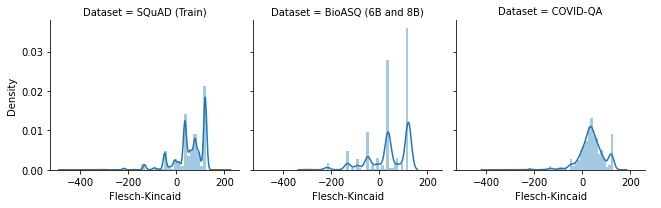

In [ ]:
flesch_kincaid0=[(textstat.flesch_reading_ease(x),"SQuAD (Train)")  for x in train_answers0]
flesch_kincaid1=[(textstat.flesch_reading_ease(x),"BioASQ (6B and 8B)")  for x in train_answers1]
flesch_kincaid2=[(textstat.flesch_reading_ease(x),"COVID-QA")  for x in train_answers2]

flesch_kincaid = pd.DataFrame(flesch_kincaid0 + flesch_kincaid1 +flesch_kincaid2, columns=['Flesch-Kincaid', 'Dataset'])

# Form a facetgrid using columns with a hue 
sea = sns.FacetGrid(flesch_kincaid, col = "Dataset")
# map the above form facetgrid with some attributes   
sea.map(sns.distplot, 'Flesch-Kincaid',  hist_kws=dict( linewidth=1.2))
sea.set(ylabel="Density")
# adding legend
sea.add_legend()
# plt.subplots_adjust(hspace=0.4, wspace=0.4)

In [ ]:
flesch_kincaid.groupby('Dataset').describe().T

Dataset               BioASQ 6B and 8B     COVID-QA          SQuAD
Flesch-Kincaid count      14919.000000  2019.000000  130319.000000
               mean          40.740149    37.480287      56.035185
               std           84.217272    51.152596      65.056169
               min         -301.790000  -386.390000    -470.990000
               25%           -6.700000    13.950000      35.610000
               50%           36.620000    36.620000      66.400000
               75%          121.220000    64.370000     119.190000
               max          121.220000   151.000000     206.840000

#coleman_liau

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

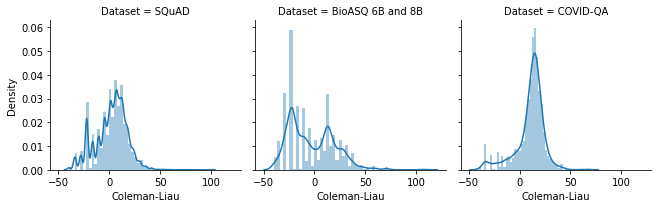

In [ ]:
coleman_liau0=[(textstat.coleman_liau_index(x),"SQuAD")  for x in train_answers0]
coleman_liau1=[(textstat.coleman_liau_index(x),"BioASQ 6B and 8B")  for x in train_answers1]
coleman_liau2=[(textstat.coleman_liau_index(x),"COVID-QA")  for x in train_answers2]

coleman_liau = pd.DataFrame(coleman_liau0 + coleman_liau1 +coleman_liau2, columns=['Coleman-Liau', 'Dataset'])

# Form a facetgrid using columns with a hue 
sea = sns.FacetGrid(coleman_liau, col = "Dataset")
# map the above form facetgrid with some attributes   
sea.map(sns.distplot, 'Coleman-Liau',  hist_kws=dict( linewidth=1.2))
sea.set(ylabel="Density")
# adding legend
sea.add_legend()
# plt.subplots_adjust(hspace=0.4, wspace=0.4)

In [ ]:
coleman_liau.groupby('Dataset').describe().T

Dataset             BioASQ 6B and 8B     COVID-QA          SQuAD
Coleman-Liau count      14919.000000  2019.000000  130319.000000
             mean          -2.716293    10.559544       2.213871
             std           22.357327    14.025679      15.268660
             min          -39.610000   -39.610000     -39.610000
             25%          -22.210000     7.100000      -6.260000
             50%           -7.410000    13.470000       4.200000
             75%           13.050000    18.050000      12.600000
             max          111.200000    68.150000      99.600000

#Gunning Fog

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

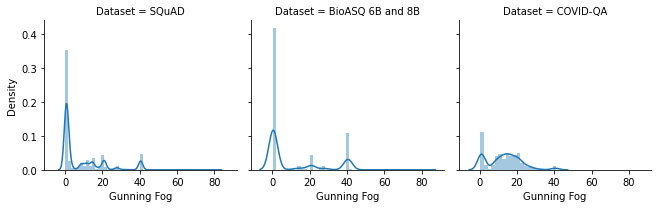

In [ ]:
gunning_fog0=[(textstat.gunning_fog(x),"SQuAD")  for x in train_answers0]
gunning_fog1=[(textstat.gunning_fog(x),"BioASQ 6B and 8B")  for x in train_answers1]
gunning_fog2=[(textstat.gunning_fog(x),"COVID-QA")  for x in train_answers2]
gunning_fog = pd.DataFrame(gunning_fog0 + gunning_fog1 +gunning_fog2, columns=['Gunning Fog', 'Dataset'])

# Form a facetgrid using columns with a hue 
sea = sns.FacetGrid(gunning_fog, col = "Dataset")
# map the above form facetgrid with some attributes   
sea.map(sns.distplot, 'Gunning Fog',  hist_kws=dict( linewidth=1.2))
sea.set(ylabel="Density")
# adding legend
sea.add_legend()
# plt.subplots_adjust(hspace=0.4, wspace=0.4)

In [ ]:
gunning_fog.groupby('Dataset').describe().T

Dataset            BioASQ 6B and 8B     COVID-QA          SQuAD
Gunning Fog count      14919.000000  2019.000000  130319.000000
            mean          10.408125    13.100362       8.424382
            std           15.891285     9.100586      11.864833
            min            0.400000     0.400000       0.000000
            25%            0.400000     6.170000       0.400000
            50%            0.400000    13.900000       1.200000
            75%           20.800000    18.900000      14.530000
            max           80.400000    41.200000      80.400000

#automated_readability_index

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

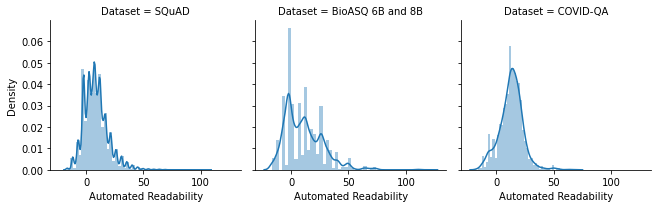

In [ ]:
automated_readability0=[(textstat.automated_readability_index(x),"SQuAD")  for x in train_answers0]
automated_readability1=[(textstat.automated_readability_index(x),"BioASQ 6B and 8B")  for x in train_answers1]
automated_readability2=[(textstat.automated_readability_index(x),"COVID-QA")  for x in train_answers2]

automated_readability = pd.DataFrame(automated_readability0 + automated_readability1 +automated_readability2, columns=['Automated Readability', 'Dataset'])

# Form a facetgrid using columns with a hue 
sea = sns.FacetGrid(automated_readability, col = "Dataset")
# map the above form facetgrid with some attributes   
sea.map(sns.distplot, 'Automated Readability',  hist_kws=dict( linewidth=1.2))
sea.set(ylabel="Density")
# adding legend
sea.add_legend()
# plt.subplots_adjust(hspace=0.4, wspace=0.4)

In [ ]:
automated_readability.groupby('Dataset').describe().T

Dataset                      BioASQ 6B and 8B     COVID-QA          SQuAD
Automated Readability count      14919.000000  2019.000000  130319.000000
                      mean          10.776439    12.966469       8.640264
                      std           16.521000    10.116304      10.551412
                      min          -16.300000   -16.300000     -16.300000
                      25%           -2.200000     7.300000       1.800000
                      50%            7.300000    13.500000       7.300000
                      75%           21.500000    19.100000      14.000000
                      max          120.400000    68.600000     106.200000

#lexical_diversity

In [ ]:
lexical_diversity0=[(ld.ttr(ld.flemmatize(x)),"SQuAD")  for x in train_answers0]
lexical_diversity1=[(ld.ttr(ld.flemmatize(x)),"BioASQ 6B and 8B")  for x in train_answers1]
lexical_diversity2=[(ld.ttr(ld.flemmatize(x)),"COVID-QA")  for x in train_answers2]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

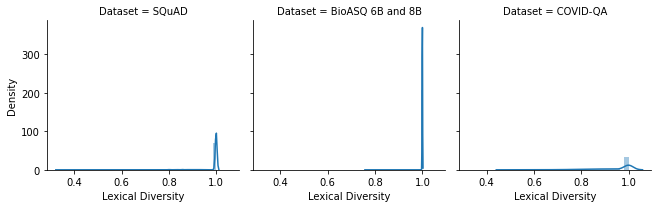

In [ ]:
lexical_diversity = pd.DataFrame(lexical_diversity0 + lexical_diversity1 +lexical_diversity2, columns=['Lexical Diversity', 'Dataset'])

# Form a facetgrid using columns with a hue 
sea = sns.FacetGrid(lexical_diversity, col = "Dataset")
# map the above form facetgrid with some attributes   
# sea.map(sns.distplot, 'Lexical Diversity',  hist_kws=dict( linewidth=1.2))
sea.map(sns.distplot, 'Lexical Diversity',  hist_kws=dict( linewidth=1.2))
sea.set(ylabel="Density")
# adding legend
sea.add_legend()
# plt.subplots_adjust(hspace=0.4, wspace=0.4)

In [ ]:
lexical_diversity.groupby('Dataset').describe().T

Dataset                  BioASQ 6B and 8B     COVID-QA          SQuAD
Lexical Diversity count      14919.000000  2019.000000  130319.000000
                  mean           0.999709     0.938728       0.990625
                  std            0.006637     0.090530       0.039972
                  min            0.760000     0.500000       0.333333
                  25%            1.000000     0.888889       1.000000
                  50%            1.000000     1.000000       1.000000
                  75%            1.000000     1.000000       1.000000
                  max            1.000000     1.000000       1.000000